In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm  

df = pd.read_csv("QSurvey_Synthetic.csv", encoding='ISO-8859-1')
df['Treatment'] = df['FL_22_DO'].apply(lambda x: 1 if x == 'FL_24' else 0)



                            OLS Regression Results                            
Dep. Variable:                    DV1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                  0.002676
Date:                Tue, 15 Jul 2025   Prob (F-statistic):              0.959
Time:                        18:19:25   Log-Likelihood:                -554.70
No. Observations:                 402   AIC:                             1113.
Df Residuals:                     400   BIC:                             1121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7015      0.068     54.434      0.0

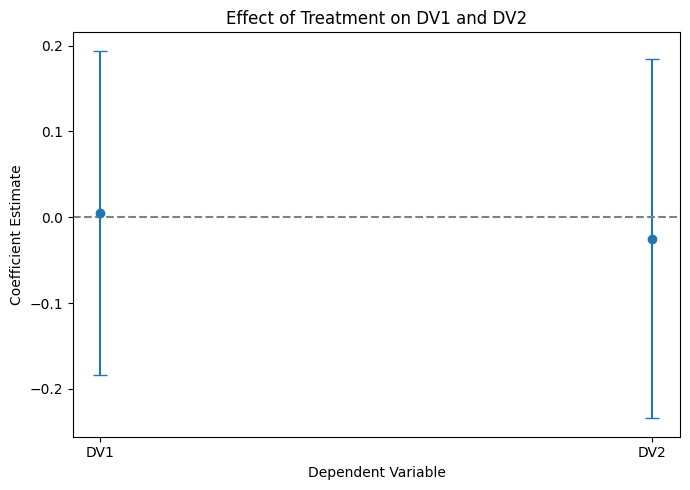

In [3]:
df_clean = df[['DV1', 'DV2', 'Treatment']].dropna()

# regressions
X = sm.add_constant(df_clean['Treatment'])

model_dv1 = sm.OLS(df_clean['DV1'], X).fit()
model_dv2 = sm.OLS(df_clean['DV2'], X).fit()

# Print summaries
print(model_dv1.summary())
print(model_dv2.summary())

# Prepare data for plotting
coef_data = pd.DataFrame({
    'DV': ['DV1', 'DV2'],
    'coef': [model_dv1.params['Treatment'], model_dv2.params['Treatment']],
    'ci_low': [model_dv1.conf_int().loc['Treatment'][0], model_dv2.conf_int().loc['Treatment'][0]],
    'ci_high': [model_dv1.conf_int().loc['Treatment'][1], model_dv2.conf_int().loc['Treatment'][1]]
})

# Plot
plt.figure(figsize=(7, 5))
plt.errorbar(coef_data['DV'], coef_data['coef'], 
             yerr=[coef_data['coef'] - coef_data['ci_low'], coef_data['ci_high'] - coef_data['coef']], 
             fmt='o', capsize=5)
plt.axhline(0, color='grey', linestyle='--')
plt.title('Effect of Treatment on DV1 and DV2')
plt.ylabel('Coefficient Estimate')
plt.xlabel('Dependent Variable')
plt.tight_layout()
plt.show()

In [ ]:
# Moderator: Ideology - does being more or less variable have any impact with or without rhetorical bypassing?
df_subset = df[['DV2', 'FL_22_DO', 'Q4']].dropna()
df_subset = df_subset[df_subset['Q4'].isin(['Very liberal', 'Liberal', 'Moderate', 'Conservative', 'Very conservative'])]
df_subset['treatment'] = (df_subset['FL_22_DO'] == 'FL_24').astype(int)
df_subset['ideology'] = df_subset['Q4'].map({
    'Very liberal': 1,
    'Liberal': 2,
    'Moderate': 3,
    'Conservative': 4,
    'Very conservative': 5
})

# Filter to liberals and moderates only (ideology ≤ 3)
df_liberal = df_subset[df_subset['ideology'] <= 3]

# Add interaction term
df_liberal['interaction'] = df_liberal['treatment'] * df_liberal['ideology']

# Regression with interaction term
X_liberal = df_liberal[['treatment', 'ideology', 'interaction']]
X_liberal = sm.add_constant(X_liberal)
y_liberal = df_liberal['DV2']

model_liberal = sm.OLS(y_liberal, X_liberal).fit()
model_liberal.summary()


/tmp/ipykernel_1653/3831405517.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_liberal['interaction'] = df_liberal['treatment'] * df_liberal['ideology']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DV2   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     3.319
Date:                Tue, 15 Jul 2025   Prob (F-statistic):             0.0209
Time:                        18:19:46   Log-Likelihood:                -287.16
No. Observations:                 207   AIC:                             582.3
Df Residuals:                     203   BIC:                             595.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.2805      0.298      7.651      0.000       1.693       2.868
treatment      -0.8184      0.408     -2.005      0.046      -1.623      -0.014
ideology        0.0206      0.136      0.151      0.880      -0.248       0.289
interaction     0.3781      0.186      2.032      0.044       0.011       0.745
==============================================================================
Omnibus:                       12.175   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                9.044
Skew:                           0.400   Prob(JB):                       0.0109
Kurtosis:                       2.362   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/tmp/ipykernel_1653/1952746345.py:15: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=coef_df, y='term', x='coef', join=False)


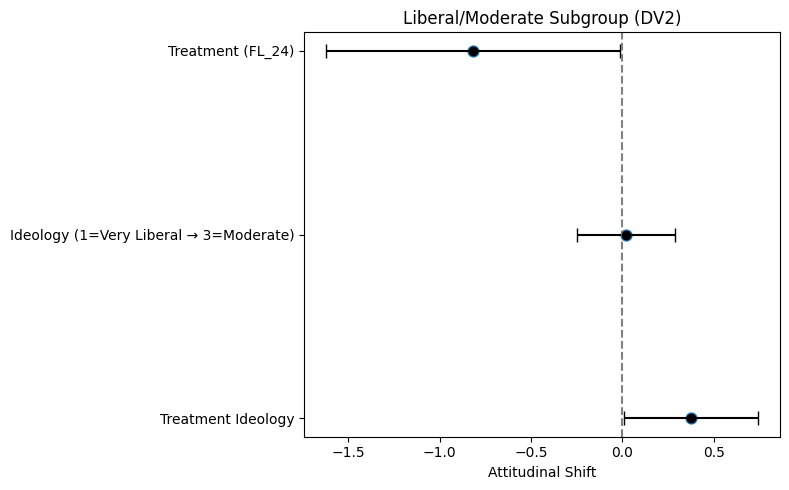

In [7]:
coef_df = model_liberal.conf_int().reset_index()
coef_df.columns = ['term', 'ci_lower', 'ci_upper']
coef_df['coef'] = model_liberal.params.values
coef_df = coef_df[coef_df['term'] != 'const']

term_map = {
    'treatment': 'Treatment (FL_24)',
    'ideology': 'Ideology (1=Very Liberal → 3=Moderate)',
    'interaction': 'Treatment Ideology'
}
coef_df['term'] = coef_df['term'].map(term_map)

# Plot the coefficients
plt.figure(figsize=(8, 5))
sns.pointplot(data=coef_df, y='term', x='coef', join=False)
plt.errorbar(
    x=coef_df['coef'], y=coef_df['term'],
    xerr=[coef_df['coef'] - coef_df['ci_lower'], coef_df['ci_upper'] - coef_df['coef']],
    fmt='o', color='black', capsize=5
)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Liberal/Moderate Subgroup (DV2)')
plt.xlabel('Attitudinal Shift')
plt.ylabel('')
plt.tight_layout()
plt.show()


In [ ]:
#NEW SECTION: SYNTHETIC DVs
#The themes I outlined in my theory are:
# (1) Backlash and Defensive nationalism (2) Normative shifts (3) Trust (4) Distinguishing ppl from gov

#DV1 Attitudes toward the speaker: trust, distinction, norms
## Q10: Do you believe the Canadian Prime Minister's criticism was sincere?
## Q11 Did the message make you feel more favorable toward the Canadian gov?
## Q14 How would you rate yout feelings toward the Canadian prime minister?

#DV2 Attitudes toward their gov: backlash/defensive nationalism, norm, viable audiences
##Q9 I support the US gov
##Q12 I feel more critical of the US gov after reading the article
##Q13 I believe the US should reconsider its current approach.

''' 
Pre Questions:
Q4 My political preferences lean...
o	Very liberal  (1) 
o	Liberal  (2) 
o	Moderate  (3) 
o	Conservative  (4) 
o	Very conservative  (5) 
o	Prefer not to say  (6) 

Q5 I take pride in the U.S. Constitution and feel that its core values align with my personal beliefs.
o	Strongly disagree  (1) 
o	Somewhat disagree  (2) 
o	Neither agree nor disagree  (3) 
o	Somewhat agree  (4) 
o	Strongly agree  (5) 

Q6 I would rather be a citizen of America than any other country.
o	Strongly disagree  (1) 
o	Somewhat disagree  (2) 
o	Neither agree nor disagree  (3) 
o	Somewhat agree  (4) 
o	Strongly agree  (5) 

Q7 It would be disrespectful for myself or another American to criticize U.S. policies.
o	Strongly disagree  (1) 
o	Somewhat disagree  (2) 
o	Neither agree nor disagree  (3) 
o	Somewhat agree  (4) 
o	Strongly agree  (5) 

'''

'''
Q8 At this moment, which government do you feel most morally aligned with?
o	The United States  
o	Canada  
o	Neither  
o	Other (please specify)  

Q9 Indicate your level of agreement:   I felt the need to defend and support the U.S. after reading the Prime Minister's remarks.
o	Strongly disagree  
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree  

Q10 The Prime Minister's remarks reflect my own concerns and I felt understood, even if I felt the need to defend the U.S.
o	Strongly disagree  
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree  

Q11 I believe the Prime Minister’s message was sincere.
o	Strongly disagree   
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree 

Q12 I support the Prime Minister's right to comment on this issue.
o	Strongly disagree  
o	Somewhat disagree  
o	Neither agree nor disagree  
o	Somewhat agree  
o	Strongly agree  

Q13 After reading this article, my view on the Canadian Prime Minister is...
o	Extremely negative  
o	Somewhat negative  
o	Neither positive nor negative  
o	Somewhat positive  
o	Extremely positive  

Q14 After reading this article, my view of the U.S. government is... 
o	Extremely negative  
o	Somewhat negative  
o	Neither positive nor negative  
o	Somewhat negative  
o	Somewhat positive  

Q15 Based on the article you read, how much do you support the U.S. government's data policy?
o	Not at all  
o	Slightly  
o	Somewhat  
o	Mostly  
o	Extremely  
o	Not sure  

'''

